# Visión Artificial con CNN (32×32 / 64×64) — Notebook didáctico

**Objetivo:** entrenar una CNN sobre imágenes *más complejas* (CIFAR-10) y visualizar, capa a capa, cómo se transforman en **mapas de características**.

Este notebook está pensado para docencia: explicación clara de **capas** y **entrenamiento**, más visualizaciones para entender cómo la IA “ve”.

**Pipeline**
1. Cargar dataset (CIFAR-10) y preparar datos (normalización + split).
2. Definir CNN (con nombres de capa y comentarios).
3. Entrenar (epochs, batches, loss, optimizer, callbacks).
4. Evaluar (accuracy + matriz de confusión).
5. Visualizar: imagen original → activaciones tras conv/pooling → Grad-CAM opcional.

> Nota operativa: `keras.datasets.cifar10` descarga el dataset la primera vez y lo deja en caché local (en `~/.keras/datasets`). Para una sesión presencial sin internet, ejecútalo una vez antes para “precargar”.


## 0) Setup

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ================================
# CONFIGURACIÓN DIDÁCTICA
# ================================
IMG_SIZE = 32            # Puedes cambiar a 64 (reescala CIFAR-10)
FAST_DEMO = False        # True => entrena rápido (submuestra y menos epochs)
EPOCHS = 12 if not FAST_DEMO else 3
BATCH_SIZE = 128

SEED = 42
np.random.seed(SEED)

# ================================
# TENSORFLOW / KERAS
# ================================
TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    TF_AVAILABLE = False
    print("[ERROR] TensorFlow no disponible:", repr(e))
    print("Instalación típica: pip install tensorflow")

print("TF_AVAILABLE =", TF_AVAILABLE)
if TF_AVAILABLE:
    print("TensorFlow:", tf.__version__)

c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

TF_AVAILABLE = True
TensorFlow: 2.20.0


## 1) Datos: CIFAR-10 (32×32 RGB)

**CIFAR-10** contiene 10 clases (objetos cotidianos). Es ideal para docencia porque:
- Las imágenes son reales y variadas.
- Son más complejas que dígitos 8×8.
- Las CNN muestran claramente su ventaja.

Aquí:
- Cargamos train/test.
- Normalizamos (0–255 → 0–1).
- (Opcional) reescalamos a 64×64 para visualización más clara.


In [8]:
if not TF_AVAILABLE:
    raise RuntimeError("TensorFlow no disponible: este notebook requiere TF/Keras para la CNN.")

from tensorflow.keras.datasets import cifar10

# 1) Cargar dataset (primera vez: descarga y deja caché local)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etiquetas vienen como (N,1); las dejamos como (N,)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

# 2) Normalización (CRÍTICO para entrenamiento estable)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# 3) Reescalar si IMG_SIZE != 32 (didáctico)
if IMG_SIZE != 32:
    x_train = tf.image.resize(x_train, [IMG_SIZE, IMG_SIZE]).numpy()
    x_test  = tf.image.resize(x_test,  [IMG_SIZE, IMG_SIZE]).numpy()

print("Luego de normalizar / reescalar:")
print("Train:", x_train.shape, "min/max:", x_train.min(), x_train.max())

Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)
Luego de normalizar / reescalar:
Train: (50000, 32, 32, 3) min/max: 0.0 1.0


## 2) Visualización de entrada

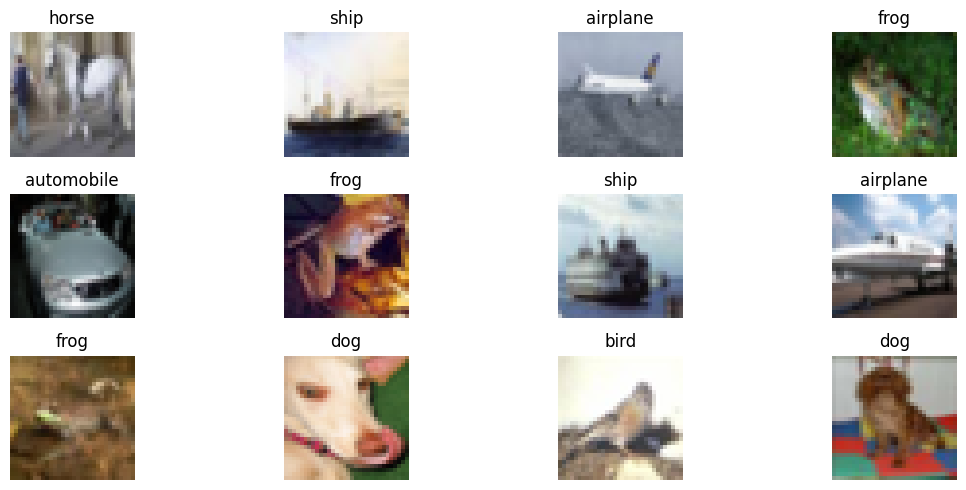

In [9]:
def show_samples(images, labels, n=12):
    plt.figure(figsize=(12, 5))
    idxs = np.random.choice(len(images), size=n, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[idx])
        plt.title(class_names[int(labels[idx])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train, n=12)

## 3) Modelo: CNN explicada capa por capa

### Arquitectura
Usaremos 2 bloques convolucionales:

**Bloque 1**
- `Conv2D(32)` + `Conv2D(32)` → aprende bordes/texturas simples
- `MaxPooling2D` → reduce resolución, conserva señales fuertes
- `Dropout` → ayuda contra overfitting

**Bloque 2**
- `Conv2D(64)` + `Conv2D(64)` → patrones más complejos
- `MaxPooling2D`
- `Dropout`

**Cabeza de clasificación**
- `Flatten` → pasa de mapas 2D a vector
- `Dense(256)` → combina features
- `Dense(10, softmax)` → probabilidades por clase


In [10]:
# Aumentación de datos (opcional): se aplica solo en entrenamiento
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.10),
    ],
    name="augmentation"
)

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10):
    # Modelo funcional para poder inspeccionar activaciones por capa con facilidad.
    inputs = keras.Input(shape=input_shape, name="input_image")

    # (A) Aumentación: mejora generalización (no cambia etiquetas)
    x = data_augmentation(inputs)

    # (B) BLOQUE 1
    # Conv2D: aprende filtros locales (kernels) que detectan patrones visuales
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu", name="conv1")(x)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu", name="conv2")(x)

    # MaxPooling: reduce H×W, hace al modelo más robusto y reduce cómputo
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Dropout: apaga activaciones al azar SOLO en entrenamiento
    x = layers.Dropout(0.25, name="drop1")(x)

    # (C) BLOQUE 2
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv3")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv4")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Dropout(0.25, name="drop2")(x)

    # (D) CABEZA DE CLASIFICACIÓN
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.50, name="drop3")(x)

    # Softmax => probabilidades por clase (suman 1)
    outputs = layers.Dense(num_classes, activation="softmax", name="class_probs")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_cifar10_didactica")
    return model

cnn = build_cnn()
cnn.summary()

Model: "cnn_cifar10_didactica"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_probs (Dense)             │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,970 (4.26 MB)

 Trainable params: 1,116,970 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

## 4) Entrenamiento: qué está ocurriendo (paso a paso)

Entrenar = ajustar parámetros para minimizar un **loss**.

- **Loss:** `SparseCategoricalCrossentropy` (clasificación multiclase con etiquetas enteras).
- **Optimizador:** Adam (actualiza pesos usando gradientes).
- **Batch:** número de imágenes por actualización.
- **Epoch:** una pasada completa por el dataset.
- **Validación:** mide generalización para detectar overfitting.

Incluimos callbacks:
- **ModelCheckpoint:** guarda el mejor modelo en validación.
- **EarlyStopping:** detiene si la validación no mejora.


In [11]:
from tensorflow.keras import callbacks

# 1) Compilar: define "cómo aprende" el modelo
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# 2) Callbacks (práctica profesional)
ckpt_path = "cnn_cifar10_best.keras"
cb = [
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_acc", patience=3, restore_best_weights=True, verbose=1),
]

# 3) Submuestreo (si FAST_DEMO=True)
if FAST_DEMO:
    n_train, n_test = 8000, 2000
    x_train_use, y_train_use = x_train[:n_train], y_train[:n_train]
    x_test_use, y_test_use   = x_test[:n_test],   y_test[:n_test]
else:
    x_train_use, y_train_use = x_train, y_train
    x_test_use, y_test_use   = x_test,  y_test

# 4) Fit: aquí ocurre backpropagation + actualización de pesos
history = cnn.fit(
    x_train_use, y_train_use,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    verbose=1
)

Epoch 1/12
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.2784 - loss: 1.9364
Epoch 1: val_acc improved from None to 0.48067, saving model to cnn_cifar10_best.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - acc: 0.3592 - loss: 1.7444 - val_acc: 0.4807 - val_loss: 1.4387
Epoch 2/12
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - acc: 0.4709 - loss: 1.4580
Epoch 2: val_acc improved from 0.48067 to 0.53813, saving model to cnn_cifar10_best.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - acc: 0.4899 - loss: 1.4096 - val_acc: 0.5381 - val_loss: 1.3226
Epoch 3/12
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.5329 - loss: 1.2981
Epoch 3: val_acc improved from 0.53813 to 0.59213, saving model to cnn_cifar10_best.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - acc: 0.5478 - loss: 1.2635 - val_acc: 0.5921 - val_loss: 1.1356
Epoch 4/12
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.5765 - loss: 1.1816
Epoch 4: val_acc improved from 0.59213 to 0.64227, saving model to cnn_cifa

## 5) Curvas de entrenamiento (accuracy / loss)

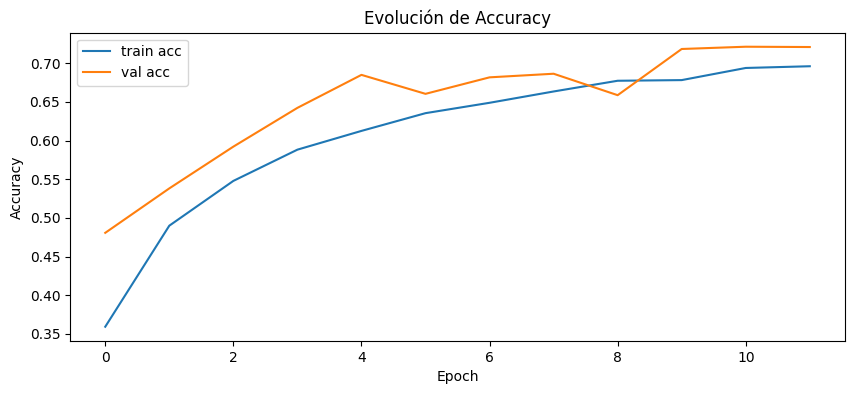

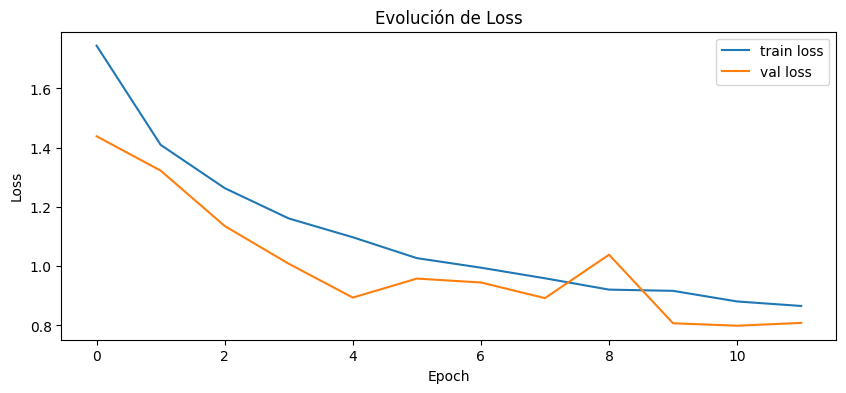

In [12]:
def plot_history(hist):
    h = hist.history

    plt.figure(figsize=(10,4))
    plt.plot(h["acc"], label="train acc")
    plt.plot(h["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(h["loss"], label="train loss")
    plt.plot(h["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Evolución de Loss")
    plt.legend()
    plt.show()

plot_history(history)

## 6) Evaluación en test + matriz de confusión

Test accuracy: 0.7146


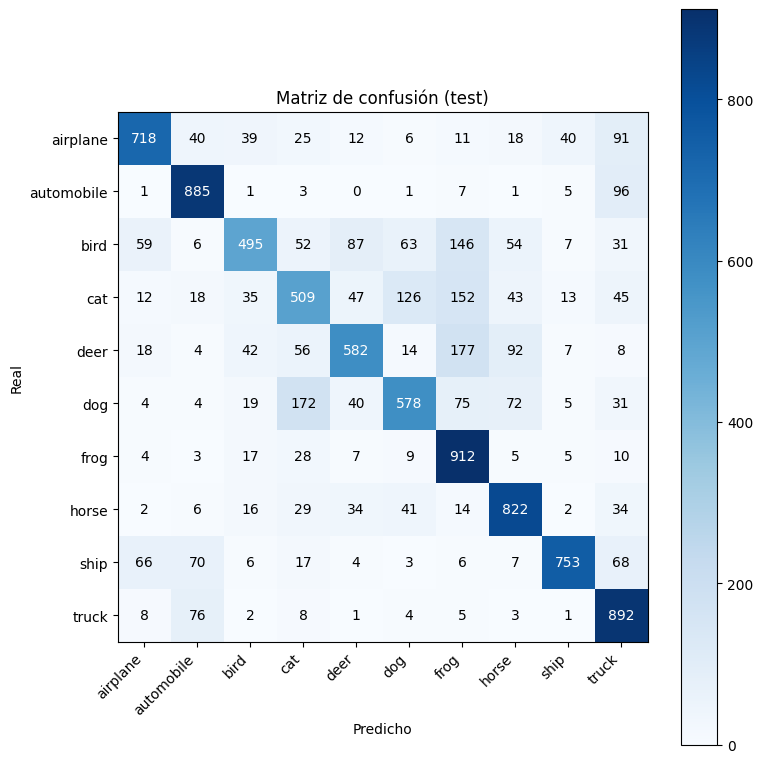

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Predicciones
probs = cnn.predict(x_test_use, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Accuracy
acc = accuracy_score(y_test_use, y_pred)
print("Test accuracy:", round(acc, 4))

# Matriz de confusión
cm = confusion_matrix(y_test_use, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión (test)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

# --- ANOTACIONES NUMÉRICAS ---
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=10
        )

plt.tight_layout()
plt.show()


## 7) Visualización de activaciones: imagen → conv/pool → mapas de características

Mostramos, para una imagen:
- salida de `conv1`
- salida de `pool1`
- salida de `conv3`
- salida de `pool2`

Esto ayuda a instalar la idea:
- capas tempranas: bordes/contrastes
- pooling: reduce resolución, conserva señales
- capas posteriores: patrones más complejos


Real: frog | Pred: frog


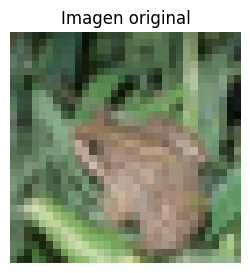

conv1 -> (32, 32, 32)


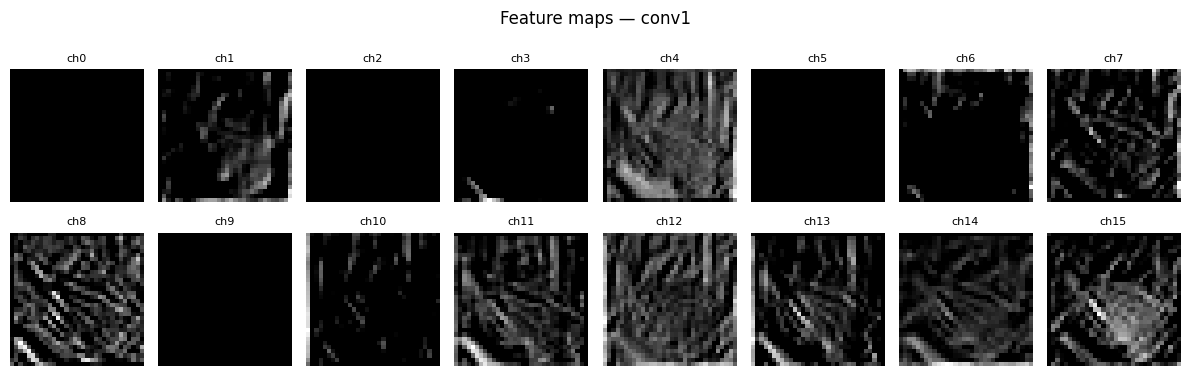

pool1 -> (16, 16, 32)


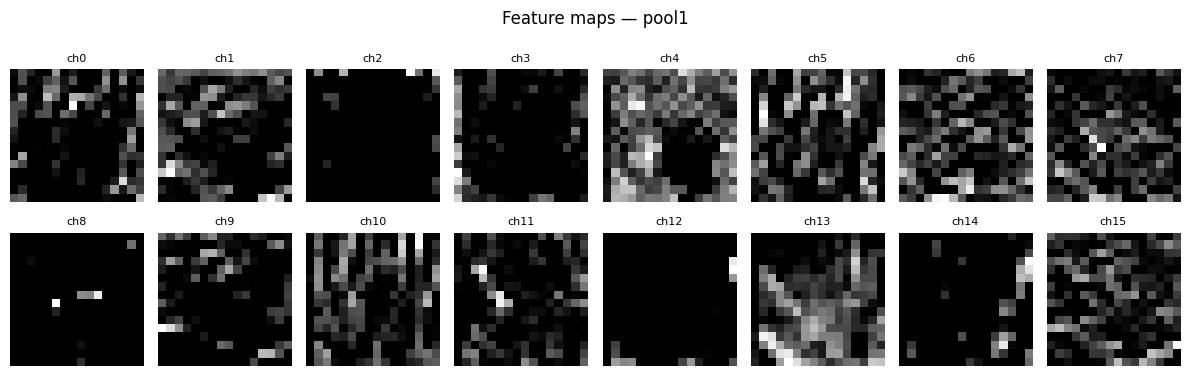

conv3 -> (16, 16, 64)


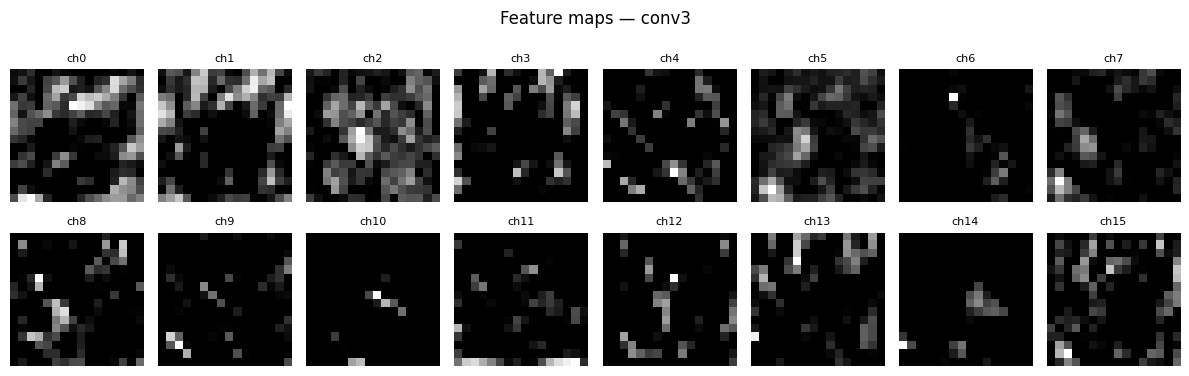

pool2 -> (8, 8, 64)


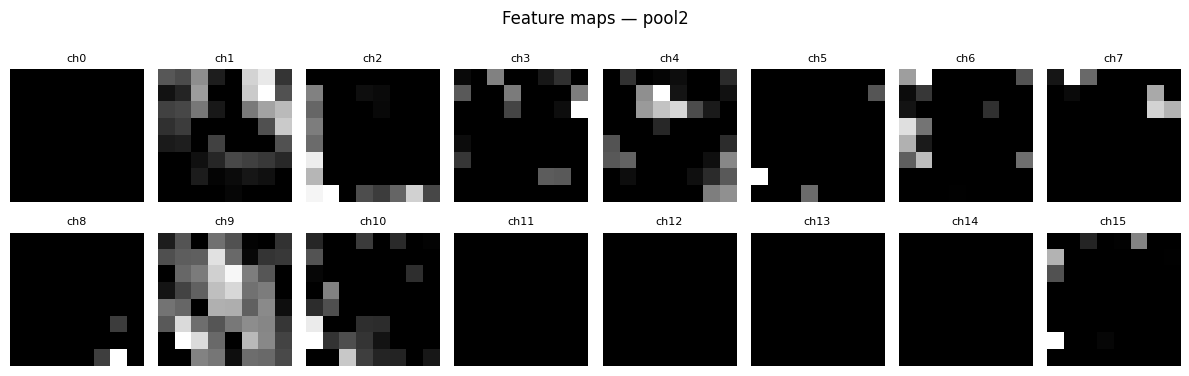

In [21]:
# Modelo auxiliar que devuelve activaciones intermedias
layer_names = ["conv1", "pool1", "conv3", "pool2"]
intermediate_outputs = [cnn.get_layer(name).output for name in layer_names]
activation_model = keras.Model(inputs=cnn.input, outputs=intermediate_outputs)

def show_feature_maps(feature_maps, max_channels=16, title=""):
    # feature_maps: (H,W,C)
    H, W, C = feature_maps.shape
    n = min(C, max_channels)

    cols = 8
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(feature_maps[..., i], cmap="gray")
        plt.axis("off")
        plt.title(f"ch{i}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Elegimos una imagen del test
idx = 4
x0 = x_test_use[idx:idx+1]
y0 = int(y_test_use[idx])

pred0 = int(np.argmax(cnn.predict(x0, verbose=0), axis=1)[0])
print("Real:", class_names[y0], "| Pred:", class_names[pred0])

plt.figure(figsize=(3,3))
plt.imshow(x0[0])
plt.title("Imagen original")
plt.axis("off")
plt.show()

acts = activation_model.predict(x0, verbose=0)
for name, act in zip(layer_names, acts):
    fmap = act[0]  # (H,W,C)
    print(name, "->", fmap.shape)
    show_feature_maps(fmap, max_channels=16, title=f"Feature maps — {name}")

## 8) (Opcional) Visualizar kernels aprendidos en `conv1`

Shape de los kernels: (3, 3, 3, 32)
Esto significa: (alto, ancho, canales RGB, cantidad de filtros)

KERNEL 0 — valores numéricos completos (3x3x3):
[[[-0.06 -0.09 -0.12]
  [-0.06  0.01 -0.09]
  [-0.02  0.05 -0.05]]

 [[-0.16 -0.02 -0.02]
  [-0.   -0.13  0.11]
  [-0.11 -0.02  0.13]]

 [[-0.15 -0.04  0.25]
  [-0.07  0.08  0.09]
  [-0.2  -0.02  0.06]]]

Canal ROJO:
[[-0.06 -0.06 -0.02]
 [-0.16 -0.   -0.11]
 [-0.15 -0.07 -0.2 ]]

Canal VERDE:
[[-0.09  0.01  0.05]
 [-0.02 -0.13 -0.02]
 [-0.04  0.08 -0.02]]

Canal AZUL:
[[-0.12 -0.09 -0.05]
 [-0.02  0.11  0.13]
 [ 0.25  0.09  0.06]]


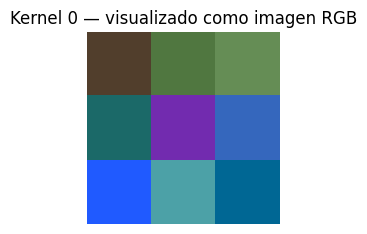

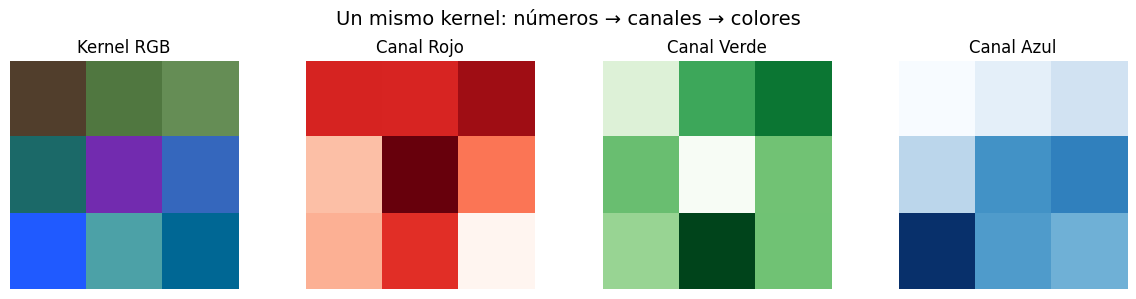

In [17]:
# =========================================================
# SECCIÓN: ¿QUÉ ES REALMENTE UN KERNEL CONVOLUCIONAL?
# De números → canales → colores
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Extraer los pesos (kernels) de la primera capa conv
# ---------------------------------------------------------
# Nota: esta capa debe llamarse "conv1" en el modelo
conv1_layer = cnn.get_layer("conv1")

# kernels shape: (alto, ancho, canales, filtros)
kernels, bias = conv1_layer.get_weights()

print("Shape de los kernels:", kernels.shape)
print("Esto significa: (alto, ancho, canales RGB, cantidad de filtros)")

# ---------------------------------------------------------
# 2) Ver un kernel específico como números
# ---------------------------------------------------------
# Seleccionamos el primer kernel (filtro 0)
k0 = kernels[:, :, :, 0]   # shape: (3, 3, 3)

# Configuración para imprimir números legibles
np.set_printoptions(precision=2, suppress=True)

print("\nKERNEL 0 — valores numéricos completos (3x3x3):")
print(k0)

print("\nCanal ROJO:")
print(k0[:, :, 0])

print("\nCanal VERDE:")
print(k0[:, :, 1])

print("\nCanal AZUL:")
print(k0[:, :, 2])

# ---------------------------------------------------------
# 3) Visualizar el mismo kernel como imagen RGB
# ---------------------------------------------------------
# Normalizamos los valores para que se puedan mostrar como colores
k_vis = k0.copy()
k_min, k_max = k_vis.min(), k_vis.max()
k_vis = (k_vis - k_min) / (k_max - k_min + 1e-9)

plt.figure(figsize=(2.5, 2.5))
plt.imshow(k_vis)
plt.title("Kernel 0 — visualizado como imagen RGB")
plt.axis("off")
plt.show()

# ---------------------------------------------------------
# 4) Comparación visual: kernel RGB vs canales separados
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].imshow(k_vis)
axes[0].set_title("Kernel RGB")
axes[0].axis("off")

axes[1].imshow(k0[:, :, 0], cmap="Reds")
axes[1].set_title("Canal Rojo")
axes[1].axis("off")

axes[2].imshow(k0[:, :, 1], cmap="Greens")
axes[2].set_title("Canal Verde")
axes[2].axis("off")

axes[3].imshow(k0[:, :, 2], cmap="Blues")
axes[3].set_title("Canal Azul")
axes[3].axis("off")

plt.suptitle("Un mismo kernel: números → canales → colores", fontsize=14)
plt.tight_layout()
plt.show()


kernels shape: (3, 3, 3, 32)


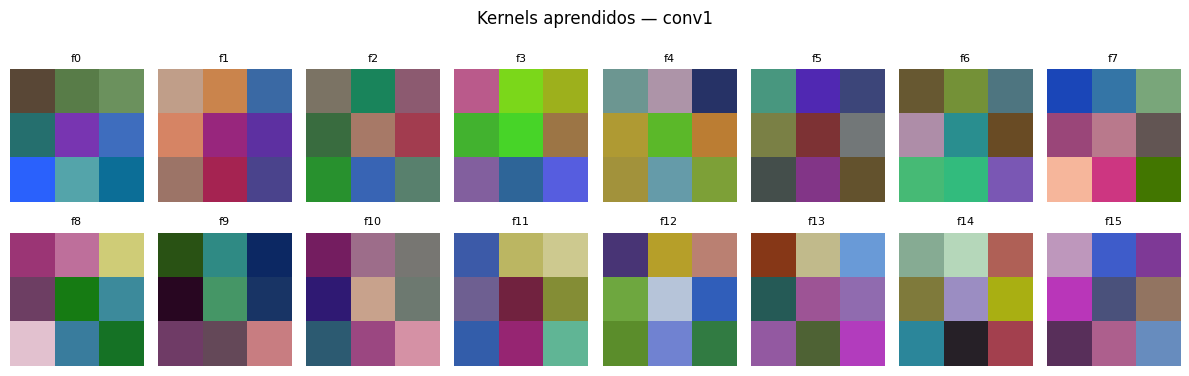

In [18]:
conv1_layer = cnn.get_layer("conv1")
kernels, bias = conv1_layer.get_weights()  # (3,3,3,32)
print("kernels shape:", kernels.shape)

def show_kernels_rgb(kernels, n=16):
    k = kernels.copy()
    k_min, k_max = k.min(), k.max()
    k = (k - k_min) / (k_max - k_min + 1e-9)

    cols = 8
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(k[:, :, :, i])
        plt.axis("off")
        plt.title(f"f{i}", fontsize=8)
    plt.suptitle("Kernels aprendidos — conv1")
    plt.tight_layout()
    plt.show()

show_kernels_rgb(kernels, n=16)

## 9) (Opcional) Grad-CAM: “dónde miró” el modelo para decidir

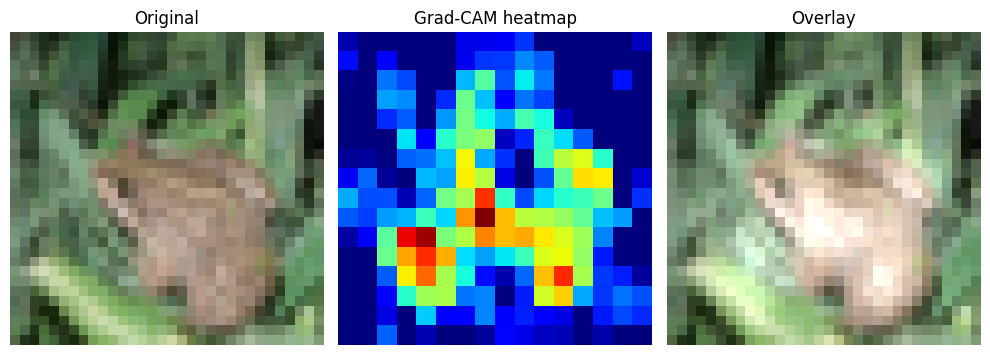

In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv4", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-9)
    return heatmap.numpy()


img = x_test_use[idx:idx+1]
heatmap = make_gradcam_heatmap(img, cnn, last_conv_layer_name="conv4")

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img[0])
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM heatmap")
plt.axis("off")

heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], [IMG_SIZE, IMG_SIZE]).numpy().squeeze()
overlay = np.clip(img[0] + 0.5 * heatmap_resized[..., np.newaxis], 0, 1)

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

## 10) Cierre: conexión con prensa/documentos

Este notebook es de **visión general** (objetos).  
Para prensa/documentos, el pipeline completo es:

1) **Clasificación de página** (portada/noticia/aviso/tabla/gráfico).  
2) **Detección** (cajas: dónde está el artículo / tabla).  
3) **OCR** (convertir región a texto).  
4) **Clasificación de artículo** (tema/sección).  
5) **Identificación** (matching / búsqueda por similitud).

Mensaje clave:
“Una CNN aprende representaciones visuales; un sistema real integra visión + OCR + clasificación + búsqueda.”
